<a href="https://colab.research.google.com/github/NicolasPCS/Image-Classification/blob/main/VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install livelossplot

import os
from keras.models import Model
from keras.optimizers import Adam, RMSprop
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np
from livelossplot.inputs.keras import PlotLossesCallback

from google.colab import drive
import os

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
BATCH_SIZE = 16

train_generator = ImageDataGenerator(rotation_range=90,
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5,
                                     height_shift_range=0.5,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing

download_dir = Path('/content/drive/MyDrive/Tesis/New_Images_Dataset')

train_data_dir = download_dir/'training_set'
test_data_dir =download_dir/'validation_set'

class_subset = sorted(os.listdir(download_dir/'training_set'))[:16] # Using only the first 10 classes
#class_subset = len(os.listdir(test_data_dir))

traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 5590 images belonging to 16 classes.
Found 978 images belonging to 16 classes.
Found 2487 images belonging to 16 classes.


In [ ]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers

    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG19(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.0001)
n_classes=16

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 50

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
#vgg_model.summary()

In [ ]:
plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

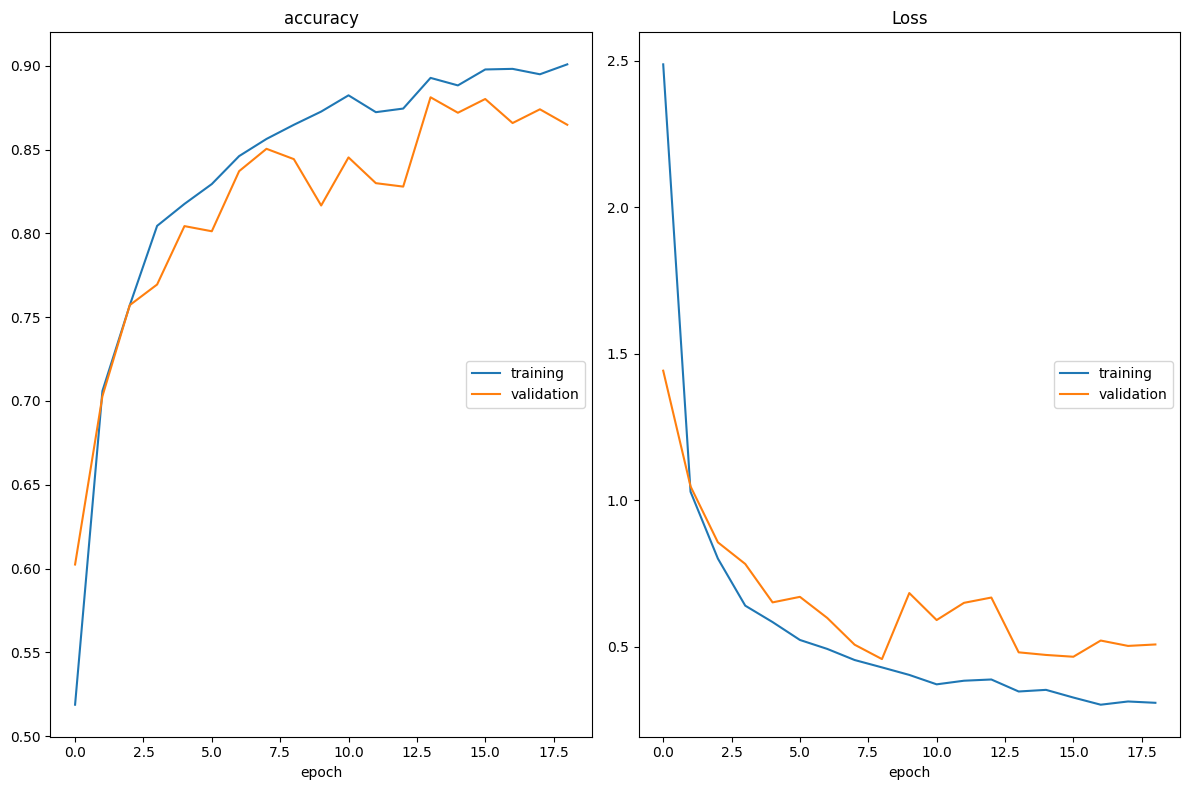

accuracy
	training         	 (min:    0.519, max:    0.901, cur:    0.901)
	validation       	 (min:    0.602, max:    0.881, cur:    0.865)
Loss
	training         	 (min:    0.302, max:    2.487, cur:    0.309)
	validation       	 (min:    0.458, max:    1.442, cur:    0.508)
349/349 [==============================] - 104s 298ms/step - loss: 0.3090 - accuracy: 0.9008 - val_loss: 0.5080 - val_accuracy: 0.8648
CPU times: user 34min 6s, sys: 1min 14s, total: 35min 20s
Wall time: 1h 10min 22s


In [ ]:
%%time

vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [ ]:
# Generate predictions
vgg_model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

2487/2487 [==============================] - 896s 360ms/step


In [ ]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy without Fine-Tuning: 39.73%


In [ ]:
# Reset our image data generators
traingen.reset()
validgen.reset()
testgen.reset()

# Use a smaller learning rate
optim_2 = Adam(learning_rate=0.0001)

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
vgg_model_ft = create_model(input_shape, n_classes, optim_2, fine_tune=2)

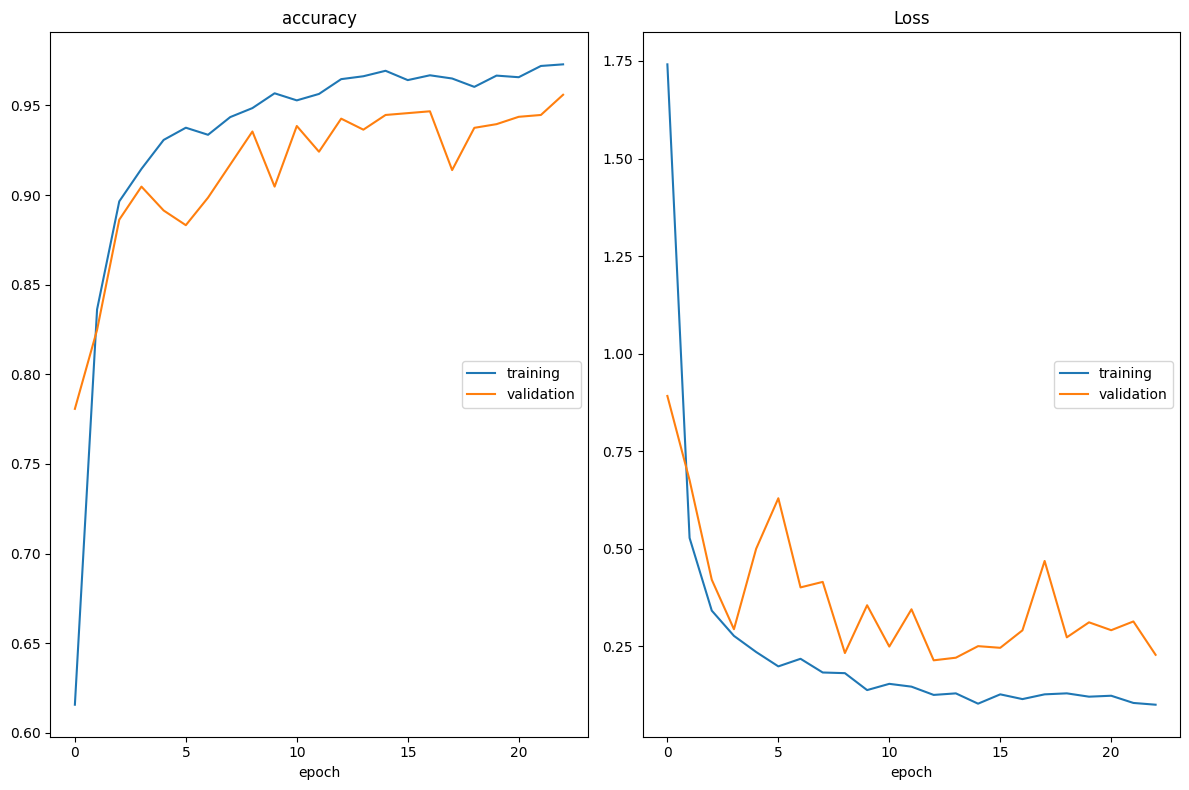

accuracy
	training         	 (min:    0.616, max:    0.973, cur:    0.973)
	validation       	 (min:    0.781, max:    0.956, cur:    0.956)
Loss
	training         	 (min:    0.101, max:    1.741, cur:    0.101)
	validation       	 (min:    0.214, max:    0.892, cur:    0.229)
349/349 [==============================] - 103s 294ms/step - loss: 0.1008 - accuracy: 0.9729 - val_loss: 0.2286 - val_accuracy: 0.9559
CPU times: user 41min 25s, sys: 1min 11s, total: 42min 36s
Wall time: 40min 18s


In [ ]:
%%time

plot_loss_2 = PlotLossesCallback()

# Retrain model with fine-tuning
vgg_ft_history = vgg_model_ft.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps,
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],
                                  verbose=1)

In [ ]:
# Generate predictions
vgg_model_ft.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

vgg_preds_ft = vgg_model_ft.predict(testgen)
vgg_pred_classes_ft = np.argmax(vgg_preds_ft, axis=1)

2487/2487 [==============================] - 31s 13ms/step


In [ ]:
vgg_acc_ft = accuracy_score(true_classes, vgg_pred_classes_ft)
print("VGG16 Model Accuracy with Fine-Tuning: {:.2f}%".format(vgg_acc_ft * 100))

VGG16 Model Accuracy with Fine-Tuning: 67.67%


In [ ]:
from keras.preprocessing import image
import numpy as np

# Ruta de la imagen que deseas predecir
image_path = '/content/drive/MyDrive/Tesis/New_Images_Dataset/training_set/billete10_reverso_nuevo/train_rev_10_nuevo_003.jpg'
image_path2 = '/content/drive/MyDrive/Tesis/New_Images_Dataset/training_set/billete20_reverso_nuevo/train_rev_20_nuevo_001.jpg'
image_path3 = '/content/drive/MyDrive/Tesis/New_Images_Dataset/training_set/billete50_reverso_nuevo/train_rev_50_nuevo_003.jpg'
image_path4 = '/content/drive/MyDrive/Tesis/New_Images_Dataset/validation_set/billete100_anverso_nuevo/val_anv_100_nuevo_03.jpg'

# Cargar la imagen y aplicar las mismas transformaciones que en el conjunto de prueba
img = image.load_img(image_path4, target_size=(224, 224))  # Ajusta el tamaño según tu modelo
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)  # Agrega una dimensión de lote (batch) ya que el modelo espera lotes

# Realizar la predicción
vgg_preds_single = vgg_model.predict(img)

# Obtener la clase predicha (índice)
predicted_class_index = np.argmax(vgg_preds_single, axis=1)

# Mapear el índice de clase a la etiqueta de clase
class_indices = traingen.class_indices
class_labels = list(class_indices.keys())
predicted_class_label = class_labels[predicted_class_index[0]]

print("Clase predicha:", predicted_class_label)

1/1 [==============================] - 0s 18ms/step
Clase predicha: billete100_anverso_nuevo
